In [ ]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# LOAD DATA

In [ ]:
train = pd.read_csv("drive/My Drive/Iot_Train_data.csv")
test = pd.read_csv("drive/My Drive/Iot_Test_data.csv")

In [ ]:
print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal

[4 rows x 42 columns]
Training data has 25192 rows & 42 columns


In [ ]:
print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0         0           tcp  ...                  1.0                      1.0
1         0           tcp  ...                  1.0                      1.0
2         2           tcp  ...                  0.0                      0.0
3         0          icmp  ...                  0.0                      0.0

[4 rows x 41 columns]
Testing data has 22544 rows & 41 columns


# EXPLORATORY ANALYSIS

In [ ]:
# Descriptive statistics
train.describe()

duration  ...  dst_host_srv_rerror_rate
count  25192.000000  ...              25192.000000
mean     305.054104  ...                  0.118769
std     2686.555640  ...                  0.317333
min        0.000000  ...                  0.000000
25%        0.000000  ...                  0.000000
50%        0.000000  ...                  0.000000
75%        0.000000  ...                  0.000000
max    42862.000000  ...                  1.000000

[8 rows x 38 columns]

In [ ]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [ ]:
#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
# Attack Class Distribution
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

# SCALING NUMERICAL ATTRIBUTES

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

# ENCODING CATEGORICAL ATTRIBUTES

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()


In [ ]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [ ]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# FEATURE SELECTION

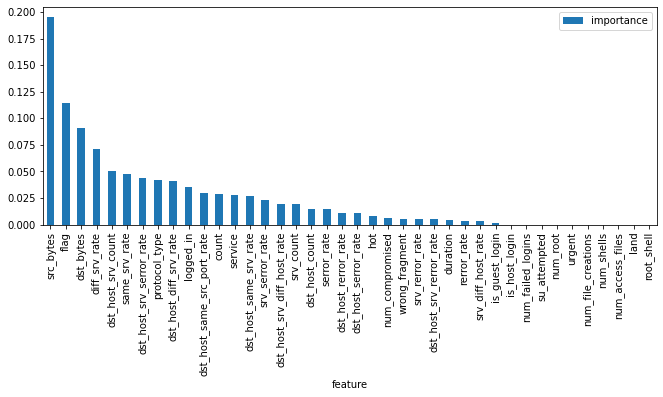

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

# DATASET PARTITION

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

# FITTING MODELS

In [ ]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

# EVALUATE MODELS

In [ ]:
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Random Forest', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9071666840303904

Model Accuracy:
 0.9071679709651809

Confusion matrix:
 [[7000 1245]
 [ 392 8997]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.95      0.85      0.90      8245
      normal       0.88      0.96      0.92      9389

    accuracy                           0.91     17634
   macro avg       0.91      0.90      0.91     17634
weighted avg       0.91      0.91      0.91     17634



============================== Random Forest Model Evaluation ==============================

Cross Validation Mean Score:
 0.9960869883971739

Model Accuracy:
 1.0

Confusion matrix:
 [[8245    0]
 [   0 9389]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.00      9389

    accur

# VALIDATING MODELS

In [ ]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.906721354855782

Confusion matrix:
 [[2981  517]
 [ 188 3872]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.94      0.85      0.89      3498
      normal       0.88      0.95      0.92      4060

    accuracy                           0.91      7558
   macro avg       0.91      0.90      0.91      7558
weighted avg       0.91      0.91      0.91      7558



============================== Random Forest Model Test Results ==============================

Model Accuracy:
 0.9947075946017465

Confusion matrix:
 [[3483   15]
 [  25 4035]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      3498
      normal       1.00      0.99      1.00      4060

    accuracy                           0.99      7558
   macro avg       0.99      0.99    

In [ ]:
# PREDICTING FOR TEST DATA using KNN
pred_knn = KNN_Classifier.predict(test_df)
pred_NB = BNB_Classifier.predict(test_df)
pred_log = LGR_Classifier.predict(test_df)
pred_dt = DTC_Classifier.predict(test_df)

# Extracting TP FP TN FN

In [ ]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual.iat[i]==y_pred[i]=='anomaly':
           TP += 1
        if y_pred[i]=='anomaly' and y_actual.iat[i]!=y_pred[i]:
           FP += 1
        if y_actual.iat[i]==y_pred[i]=='normal':
           TN += 1
        if y_pred[i]=='normal' and y_actual.iat[i]!=y_pred[i]:
           FN += 1
        
    return (TP, FP, TN, FN)


for i, v in models:
    print("For model:", i)
    TP, FP, TN, FN = perf_measure(Y_test, v.predict(X_test))
    print ("TP:", TP, "\tFP:", FP, "\t\tTN:", TN, "\tFN:", FN)
    
    # Testing for first row
    #print ("Expected: ", Y_test.iloc[0], "Predicted: ", v.predict(X_test).reshape(1, -1)[0][0] )
    print()
    

For model: Naive Baye Classifier
TP: 2981 	FP: 188 		TN: 3872 	FN: 517

For model: Random Forest
TP: 3483 	FP: 25 		TN: 4035 	FN: 15

For model: KNeighborsClassifier
TP: 3458 	FP: 23 		TN: 4037 	FN: 40

For model: LogisticRegression
TP: 3297 	FP: 138 		TN: 3922 	FN: 201



In [ ]:
# Testing for second row
for i, v in models:
    print("For model: ", i)
    print ("Expected: ", Y_test.iloc[2], "\tPredicted: ", v.predict(X_test).reshape(1, -1)[0][2] )
    print()

For model:  Naive Baye Classifier
Expected:  anomaly 	Predicted:  normal

For model:  Random Forest
Expected:  anomaly 	Predicted:  anomaly

For model:  KNeighborsClassifier
Expected:  anomaly 	Predicted:  anomaly

For model:  LogisticRegression
Expected:  anomaly 	Predicted:  anomaly



In [ ]:
type(Y_test)

pandas.core.series.Series

# Functions to extract locations of FP, FN as a pandas series

In [ ]:
def find_FP(y_actual, y_pred):
    FP = []

    for i in range(len(y_pred)): 
        if y_pred[i]=='anomaly' and y_actual.iat[i]!=y_pred[i]:
           FP.append(i)   
    return (pd.Series(FP))
    
def find_FN(y_actual, y_pred):
    FN = []

    for i in range(len(y_pred)): 
        if y_pred[i]=='normal' and y_actual.iat[i]!=y_pred[i]:
           FN.append(i)
    return (pd.Series(FN))


## Getting FP and FN row location from NB output as pd.Series

In [ ]:
FP_NB= find_FP(Y_test, models[0][1].predict(X_test))
print("Size of number of FP:", FP_NB.size) 
FN_NB= find_FN(Y_test, models[0][1].predict(X_test))
print("Size of number of FN:", FN_NB.size) 

# Testing 
FP_NB.head(4)

Size of number of FP: 188
Size of number of FN: 517


0     23
1     89
2    210
3    243
dtype: int64

## Getting FP FN row entry from X_test and Y_test as pd.DataFrame and pd.Series respectively

In [ ]:
X_test_subset=[]
Y_test_subset=[]
for i in FP_NB:
    X_test_subset.append(X_test.iloc[i])
    Y_test_subset.append(Y_test.iat[i])
for i in FN_NB:
    X_test_subset.append(X_test.iloc[i])
    Y_test_subset.append(Y_test.iat[i])
    
X_test_sub=pd.DataFrame(X_test_subset)
Y_test_sub=pd.Series(Y_test_subset)
print("Size of X_test_sub:", X_test_sub.shape[0]) 
print("Size of Y_test_sub:", Y_test_sub.size) 

# To check for each false positive
#for i in FP_NB:
#    print ("Expected: ", Y_test.iloc[i], "Predicted: ", models[1][1].predict(X_test).reshape(1, -1)[0][i] )

Size of X_test_sub: 705
Size of Y_test_sub: 705


In [ ]:
print(type(X_test)) 
X_test.head(4)

<class 'pandas.core.frame.DataFrame'>


duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
2900  -0.113551  -0.010093   -0.03931  ...              1       46     5
11640 -0.113551  -0.010081   -0.03931  ...              2       46     9
16662 -0.113551  -0.010089   -0.03931  ...              0       13     9
21545 -0.113551  -0.010093   -0.03931  ...              1       63     5

[4 rows x 40 columns]

In [ ]:
print(type(X_test_sub))
X_test_sub.head(4)


<class 'pandas.core.frame.DataFrame'>


duration  src_bytes  dst_bytes  ...  protocol_type  service  flag
719   -0.113551  -0.010080   -0.03931  ...            0.0     13.0   9.0
19908 -0.113551  -0.009527   -0.03931  ...            1.0     41.0   9.0
12516 -0.113551  -0.010080   -0.03931  ...            0.0     13.0   9.0
18475 -0.113551  -0.010017   -0.03931  ...            0.0     61.0   9.0

[4 rows x 40 columns]

In [ ]:
print(type(Y_test)) 
Y_test.head(4)

<class 'pandas.core.series.Series'>


2900     anomaly
11640    anomaly
16662    anomaly
21545    anomaly
Name: class, dtype: object

In [ ]:
print(type(Y_test_sub))
Y_test_sub.head(4)

<class 'pandas.core.series.Series'>


0    normal
1    normal
2    normal
3    normal
dtype: object

In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
import os
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

%matplotlib inline

In [ ]:
class Luong_attention_layer(nn.Module):
    def __init__(self, method, hidden_size):
        super(Luong_attention_layer, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, 'is not appropriate attention method')
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.weight = nn.Parameter(torch.FloatTensor(hidden_size))
            
    def get_dot_score(self, hidden, encoder_outputs):
        return torch.sum(hidden*encoder_outputs, dim=2)
    
    def get_general_score(self, hidden, encoder_outputs):
        energy = self.attn(encoder_outputs)
        return torch.sum(hidden * energy, dim=2)
    
    def get_concat_score(self, hidden, encoder_outputs):
        concat = torch.cat((hidden.expand(encoder_outputs.size(0),-1,-1), encoder_outputs), dim=2)
        energy = torch.tanh(self.attn(concat))
        return torch.sum(self.weight * energy, dim=2)
                           
    def forward(self, hidden, encoder_outputs):
        if self.method == 'dot':
            attn_energy = self.get_dot_score(hidden, encoder_outputs)
        elif self.method == 'general':
            attn_energy = self.get_general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energy = self.get_concat_score(hidden, encoder_outputs)
        
        ## Transpose  attn_energy
        attn_energy = attn_energy.t()
                           
        # Softmanx the attn_energy to return the weight corresponding to each encoder output
        return F.softmax(attn_energy, dim=1).unsqueeze(1)

# Validating the combined model

## Validating results for the FP FN subset in the combined model

In [ ]:
accuracy = metrics.accuracy_score(Y_test_sub, models[1][1].predict(X_test_sub))
confusion_matrix = metrics.confusion_matrix(Y_test_sub, models[1][1].predict(X_test_sub))
classification = metrics.classification_report(Y_test_sub, models[1][1].predict(X_test_sub))
print()
print('============================== {} Model Test Results =============================='.format("NB -> DT"))
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print() 


============================== NB -> DT Model Test Results ==============================

Model Accuracy:
 0.9687943262411347

Confusion matrix:
 [[508   9]
 [ 13 175]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.98      0.98      0.98       517
      normal       0.95      0.93      0.94       188

    accuracy                           0.97       705
   macro avg       0.96      0.96      0.96       705
weighted avg       0.97      0.97      0.97       705




In [ ]:
FP_NB= find_FP(Y_test, models[0][1].predict(X_test))
print("Size of number of FP:", FP_NB.size) 
FN_NB= find_FN(Y_test, models[0][1].predict(X_test))
print("Size of number of FN:", FN_NB.size) 

# Testing 
FP_NB.head(4)

Size of number of FP: 188
Size of number of FN: 517


0     23
1     89
2    210
3    243
dtype: int64

In [ ]:
print("For Random Forest:")
TP_old, FP_old, TN_old, FN_old = perf_measure(Y_test, BNB_Classifier.predict(X_test))
print ("TP:", TP_old, "\tFP:", FP_old, "\t\tTN:", TN_old, "\tFN:", FN_old)

print()
print("ForCNN -> Random Forest:")
TP_new, FP_new, TN_new, FN_new = perf_measure(Y_test_sub, DTC_Classifier.predict(X_test_sub))
print ("TP:", TP_new, "\tFP:", FP_new, "\t\tTN:", TN_new, "\tFN:", FN_new)

print()
print("For CNN-attention and Randomforest:")
tp = TP_old +TP_new
fp = FP_new
tn = TN_old +TN_new
fn = FN_new
print ("TP:", tp, "\tFP:", fp, "\t\tTN:", tn, "\tFN:", fn)

For Random Forest:
TP: 2981 	FP: 188 		TN: 3872 	FN: 517

ForCNN -> Random Forest:
TP: 508 	FP: 13 		TN: 175 	FN: 9

For CNN+RF:
TP: 3489 	FP: 13 		TN: 4047 	FN: 9


In [ ]:
acc_old= (TP_old + TN_old) / (TP_old + FP_old + TN_old + FN_old)
mis_old= (FP_old + FN_old) / (TP_old + FP_old + TN_old + FN_old)
prec_old= TP_old / (TP_old + FP_old)
sen_old= TP_old / (TP_old + FN_old)
spec_old= TN_old / (TN_old + FP_old)

acc= (tp + tn) / (tp + fp + tn + fn)
mis= (fp + fn) / (tp + fp + tn + fn)
prec= tp / (tp + fp)
sen= tp / (tp + fn)
spec= tn / (tn + fp)

print ("Accuracy")
print ("Old: ", acc_old, "\tNew: ", acc)
print ("\nMisclassification")
print ("Old: ", mis_old, "\tNew: ", mis)
print ("\nPrecision")
print ("Old: ", prec_old, "\tNew: ", prec)
print ("\nSensitivity")
print ("Old: ", sen_old, "\tNew: ", sen)
print ("\nSpecificity")
print ("Old: ", spec_old, "\tNew: ", spec)

Accuracy
Old:  0.906721354855782 	New:  0.9970891770309606

Misclassification
Old:  0.09327864514421805 	New:  0.0029108229690394285

Precision
Old:  0.9406752918901862 	New:  0.9962878355225585

Sensitivity
Old:  0.8522012578616353 	New:  0.9974271012006861

Specificity
Old:  0.9536945812807882 	New:  0.9967980295566502


# Plotting Results

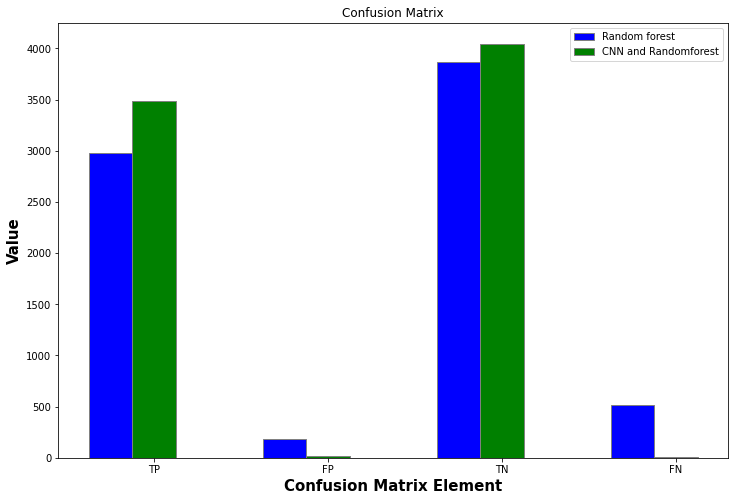

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
NB = [TP_old, FP_old, TN_old, FN_old]
NBandDT = [tp, fp, tn, fn]
 
# Set position of bar on X axis
br1 = np.arange(len(NB))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, NB, color ='b', width = barWidth, edgecolor ='grey', label ='Random forest')
plt.bar(br2, NBandDT, color ='g', width = barWidth, edgecolor ='grey', label ='CNN-attention and Randomforest')
 
# Adding Xticks
plt.xlabel('Confusion Matrix Element', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(NB))], ['TP', 'FP', 'TN', 'FN'])
 
plt.legend()
plt.title("Confusion Matrix")
plt.show()

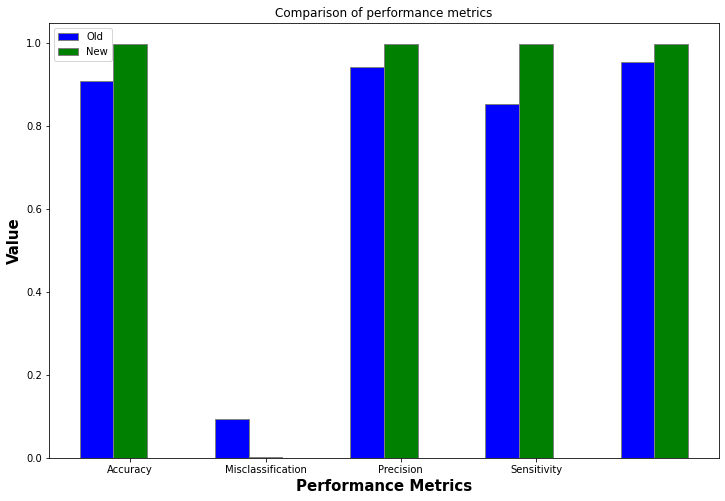

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Old = [acc_old, mis_old, prec_old, sen_old, spec_old]
New = [acc, mis, prec, sen, spec]
 
# Set position of bar on X axis
br1 = np.arange(len(Old))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, Old, color ='b', width = barWidth, edgecolor ='grey', label ='Old')
plt.bar(br2, New, color ='g', width = barWidth, edgecolor ='grey', label ='New')


# Adding Xticks
plt.xlabel('Performance Metrics', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(NB))], ['Accuracy', 'Misclassification', 'Precision', 'Sensitivity', 'Specificity'])
 
plt.legend()
plt.title("Comparison of performance metrics")
plt.show()

In [ ]:
accPercent= ((acc- acc_old)/acc_old) *100
misPercent= ((mis_old- mis)/mis_old) *100
precPercent= ((prec- prec_old)/prec_old) *100
senPercent= ((sen- sen_old)/sen_old) *100
specPercent= ((spec- spec_old)/spec_old) *100

print ("Accuracy increase percentage: " ,accPercent, "%")
print ("Missclasification decrease percentage: " ,misPercent, "%")
print ("Precison increase percentage: ", precPercent, "%")
print ("Sensitivity increase percentage: ", senPercent, "%")
print ("Specificity increase percentage: ", specPercent, "%")

Accuracy increase percentage:  9.966438056325693 %
Missclasification decrease percentage:  96.87943262411348 %
Precison increase percentage:  5.911980904763097 %
Sensitivity increase percentage:  17.041261321704123 %
Specificity increase percentage:  4.519628099173545 %
